# Classifier of Tweets

## Dependences

In [70]:
import pip
pip.main(['install', '--user', 'nltk'])

0

In [71]:
import numpy as np
from sklearn import metrics

%matplotlib inline
%run plot_learning_curve

## Load Dataset

In [72]:
import pandas as pd
 
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download("punkt")
# The files are coded in ISO-8859-1

df = pd.read_csv("tweetsCSV/Esp/train2.csv", encoding='utf-8', delimiter=",", header=0)



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [73]:
# Encode categorical variables

df.loc[df["Sleep Group"]=="y","Sleep Group"] = 1
df.loc[df["Sleep Group"]=="n","Sleep Group"] = 0


df['Sleep Group'] = df['Sleep Group'].astype(np.int64)

df.dtypes
df.head()

,text,id_str,user.id_str,Sleep Group
0,Mi productividad estalla cuando son las cinco ...,942604352887361536,278726563,1
1,tenes insomnio? ahre @Rubiu5,942601716377276416,4816224375,0
2,"Buenooooooooo,lindo insomnio voy a sufrir esta...",942973878883815424,902836699,1
3,y le converso a mi insomnio de vos,942616124256120832,231654814,1
4,Hola insomnio tanto tiempo.,942607960232079360,405899266,1


In [74]:
# Define X and Y
X = df['text'].values
y = df['Sleep Group'].values

## Lexical features

In [75]:
# Sample of statistics using nltk
# Another option is defining a function and pass it as a parameter to FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import sent_tokenize, word_tokenize

class LexicalStats (BaseEstimator, TransformerMixin):
    """Extract lexical features from each document"""
    
    def number_sentences(self, doc):
        sentences = sent_tokenize(doc, language='spanish')
        return len(sentences)

    def fit(self, x, y=None):
        return self

    def transform(self, docs):
        return [{'length': len(doc),
                 'num_sentences': self.number_sentences(doc)}
                for doc in docs]

    

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
import string

def custom_tokenizer(words):
    """Preprocessing tokens as seen in the lexical notebook"""

    urls = re.compile(r'.http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    ht = re.compile(r'http.')
    bar = re.compile(r'//*')
    pr = ["rt","@","http","https","'s",'...', 'english', 'translation','):', '. .', '..']
    #tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
    tknzr = TweetTokenizer(strip_handles=False, reduce_len=True)
    #tokens = word_tokenize(words.lower())
    tokens = tknzr.tokenize(words.lower())
    porter = PorterStemmer()
    lemmas = [porter.stem(t) for t in tokens]
    # Clean stop-words
    stoplist = stopwords.words('spanish')
    lemmas_clean = [w for w in lemmas if w not in stoplist]
    # Clean punctuation
    punctuation = set(string.punctuation)
    lemmas_punct = [w for w in lemmas_clean if  w not in punctuation]
    # Clean emojis,urls,bars,etc
    lemmas_clean = [w for w in lemmas_punct if not w.startswith('@') if w not in pr 
            if not bar.search(w) if not ht.search(w)
            if not w.isdigit()]
    
    return lemmas_clean

## Feature Extraction Pipelines

In [77]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


ngrams_featurizer = Pipeline([
  ('count_vectorizer',  CountVectorizer(ngram_range = (1, 3), encoding = 'utf-8', 
                                        tokenizer=custom_tokenizer)),
  ('tfidf_transformer', TfidfTransformer())
])

## Feature Union Pipeline

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def pipeline(clf):
    return Pipeline([
       ('features', FeatureUnion([
                    ('lexical_stats', Pipeline([
                                ('stats', LexicalStats()),
                                ('vectors', DictVectorizer())
                            ])),
                    ('words', TfidfVectorizer(tokenizer=custom_tokenizer)),
                    ('ngrams', ngrams_featurizer),
                    # Topics of the Docs
                    ('lda', Pipeline([ 
                                ('count', CountVectorizer(tokenizer=custom_tokenizer)),
                                ('lda',  LatentDirichletAllocation(n_topics=4, max_iter=5,
                                                       learning_method='online', 
                                                       learning_offset=50.,
                                                       random_state=0))
                            ])),
                ])),
        # Machine Learning
        ('clf', clf)  # classifier
        #('clf', SVC(gamma= 3, kernel='linear', probability=True))

    ])

def classification_report_with_accuracy_score(y_true, y_pred):

    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

cv = KFold(X.shape[0], n_folds=5, shuffle=False, random_state=33)


## Train, Optimize and Evaluate models


### MultinomialNB

In [19]:
from sklearn.model_selection import GridSearchCV
#Optimize multinomialNB
pipelineNB = pipeline(MultinomialNB(alpha=.001))

parametersNB = {'clf__alpha': [.0001,.001,.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

gs_NB = GridSearchCV(pipelineNB, parametersNB, n_jobs=-1)

In [20]:
gs_NB = gs_NB.fit(X, y)

In [21]:
print("Best Score with MultinomialNB: %s" % gs_NB.best_score_)
for param_name in sorted(parametersNB.keys()):
    print("%s: %r" % (param_name, gs_NB.best_params_[param_name]))

Best Score with MultinomialNB: 0.729096989967
clf__alpha: 0.1


In [22]:
#Evaluate with K-Fold
model_NB = pipeline(MultinomialNB(alpha=gs_NB.best_params_['clf__alpha'] ))
scores = cross_val_score(model_NB, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Scores in every iteration [ 0.78333333  0.8         0.68333333  0.75        0.59322034]
Accuracy: 0.72 (+/- 0.15)


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

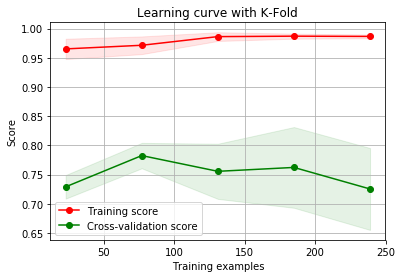

In [23]:
plot_learning_curve(model_NB, "Learning curve with K-Fold", X, y, cv=cv)

In [24]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_NB, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score)

             precision    recall  f1-score   support

          0       0.83      0.69      0.75        29
          1       0.75      0.87      0.81        31

avg / total       0.79      0.78      0.78        60

             precision    recall  f1-score   support

          0       0.93      0.71      0.81        35
          1       0.70      0.92      0.79        25

avg / total       0.83      0.80      0.80        60

             precision    recall  f1-score   support

          0       0.78      0.56      0.65        32
          1       0.62      0.82      0.71        28

avg / total       0.71      0.68      0.68        60

             precision    recall  f1-score   support

          0       0.69      0.86      0.76        28
          1       0.84      0.66      0.74        32

avg / total       0.77      0.75      0.75        60

             precision    recall  f1-score   support

          0       0.69      0.61      0.65        36
          1       0.48      0.57 

### SVC

In [25]:
from sklearn.model_selection import GridSearchCV

#Optimize SVC
pipelineSVC = pipeline(SVC(C=1,gamma= 3, kernel='linear', probability=True))

parametersSVC = {'clf__C':range(1,15),'clf__gamma': np.logspace(-6, -1, 10), 'clf__kernel': ('linear','rbf'),
                 'clf__probability':(True,False),}

gs_SVC = GridSearchCV(pipelineSVC, parametersSVC, n_jobs=-1)

In [26]:
gs_SVC= gs_SVC.fit(X,y)


In [27]:
print("Best Score with SVC: %s" % gs_SVC.best_score_)
for param_name in sorted(parametersSVC.keys()):
    print("%s: %r" % (param_name, gs_SVC.best_params_[param_name]))

Best Score with SVC: 0.769230769231
clf__C: 1
clf__gamma: 9.9999999999999995e-07
clf__kernel: 'linear'
clf__probability: True


In [28]:
#Evaluate with K-Fold
C_SVC=gs_SVC.best_params_['clf__C']
gamma_SVC = gs_SVC.best_params_['clf__gamma']
kernel_SVC = gs_SVC.best_params_['clf__kernel']
probability_SVC = gs_SVC.best_params_['clf__probability']
model_SVC = pipeline(SVC(C=C_SVC,gamma=gamma_SVC, kernel=kernel_SVC, probability=probability_SVC))
scores = cross_val_score(model_SVC, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.85        0.75        0.76666667  0.8         0.6779661 ]
Accuracy: 0.77 (+/- 0.11)


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

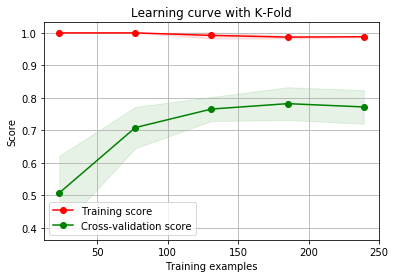

In [29]:
plot_learning_curve(model_SVC, "Learning curve with K-Fold", X, y, cv=cv)

In [30]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_SVC, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score)

             precision    recall  f1-score   support

          0       0.88      0.79      0.84        29
          1       0.82      0.90      0.86        31

avg / total       0.85      0.85      0.85        60

             precision    recall  f1-score   support

          0       0.88      0.66      0.75        35
          1       0.65      0.88      0.75        25

avg / total       0.79      0.75      0.75        60

             precision    recall  f1-score   support

          0       0.95      0.59      0.73        32
          1       0.68      0.96      0.79        28

avg / total       0.82      0.77      0.76        60

             precision    recall  f1-score   support

          0       0.81      0.75      0.78        28
          1       0.79      0.84      0.82        32

avg / total       0.80      0.80      0.80        60

             precision    recall  f1-score   support

          0       0.77      0.67      0.72        36
          1       0.57      0.70 

### KNeighborsClassifier

In [52]:
from sklearn.neighbors import KNeighborsClassifier

#Optimize KNeighborsClassifier
pipelineKN = pipeline(KNeighborsClassifier(n_neighbors=3)) 
parametersKN = {'clf__n_neighbors': range(1,15), 'clf__p':(1,2),'clf__algorithm':('ball_tree', 'kd_tree', 'brute')}

gs_KN = GridSearchCV(pipelineKN, parametersKN, n_jobs=-1)


In [53]:
gs_KN= gs_KN.fit(X,y)

/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/nei

/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/nei

/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/nei

/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/neighbors/base.py:211: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/opt/conda/lib/python3.6/site-packages/sklearn/nei

In [54]:
print("Best Score with KN: %s" % gs_KN.best_score_)
for param_name in sorted(parametersKN.keys()):
    print("%s: %r" % (param_name, gs_KN.best_params_[param_name]))

Best Score with KN: 0.642140468227
clf__algorithm: 'ball_tree'
clf__n_neighbors: 3
clf__p: 1


In [34]:
#Evaluate with K-Fold
model_KN = pipeline(KNeighborsClassifier(gs_KN.best_params_['clf__n_neighbors']))
scores = cross_val_score(model_KN, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.66666667  0.48333333  0.56666667  0.7         0.59322034]
Accuracy: 0.60 (+/- 0.15)


In [48]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_KN, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score) 

             precision    recall  f1-score   support

          0       0.65      0.69      0.67        29
          1       0.69      0.65      0.67        31

avg / total       0.67      0.67      0.67        60

             precision    recall  f1-score   support

          0       0.56      0.51      0.54        35
          1       0.39      0.44      0.42        25

avg / total       0.49      0.48      0.49        60

             precision    recall  f1-score   support

          0       0.60      0.56      0.58        32
          1       0.53      0.57      0.55        28

avg / total       0.57      0.57      0.57        60

             precision    recall  f1-score   support

          0       0.68      0.68      0.68        28
          1       0.72      0.72      0.72        32

avg / total       0.70      0.70      0.70        60

             precision    recall  f1-score   support

          0       0.75      0.50      0.60        36
          1       0.49      0.74 

### LogisticRegression


In [79]:
from sklearn.linear_model import LogisticRegression
#Optimize LogisticRegresion
pipelineLR =  pipeline(LogisticRegression(penalty='l2',tol=0.0001,C=1.0,n_jobs=-1)) 
parametersLR = {'clf__penalty': ['l1','l2'], 'clf__tol': [0.0001,0.001,0.01,0.1], 'clf__C': range(1,15)}

gs_LR = GridSearchCV(pipelineLR, parametersLR, n_jobs=-1)

In [ ]:
gs_LR= gs_LR.fit(X,y)

In [ ]:
print("Best Score with LogisticRegression: %s" % gs_LR.best_score_)
for param_name in sorted(parametersLR.keys()):
    print("%s: %r" % (param_name, gs_LR.best_params_[param_name]))

In [82]:
#Evaluate with K-Fold
# penalty_LR=gs_LR.best_params_['clf__penalty']
# tol_LR = gs_LR.best_params_['clf__tol']
# C_LR = gs_LR.best_params_['clf__C']
#model_LR = pipeline(LogisticRegression(penalty=penalty_LR,tol=tol_LR,C=C_LR,n_jobs=-1))
model_LR=pipeline(LogisticRegression(penalty='l1',tol=0.1,C=2,n_jobs=-1))
scores = cross_val_score(model_LR, X,y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.81666667  0.78333333  0.85        0.86666667  0.79661017]
Accuracy: 0.82 (+/- 0.06)


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

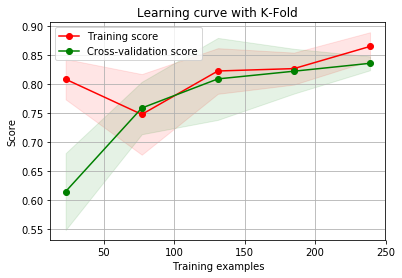

In [39]:
plot_learning_curve(model_LR, "Learning curve with K-Fold", X, y, cv=cv)

In [40]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_LR, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score) 

             precision    recall  f1-score   support

          0       0.91      0.72      0.81        29
          1       0.78      0.94      0.85        31

avg / total       0.85      0.83      0.83        60

             precision    recall  f1-score   support

          0       0.93      0.77      0.84        35
          1       0.74      0.92      0.82        25

avg / total       0.85      0.83      0.83        60

             precision    recall  f1-score   support

          0       0.81      0.81      0.81        32
          1       0.79      0.79      0.79        28

avg / total       0.80      0.80      0.80        60

             precision    recall  f1-score   support

          0       0.82      0.82      0.82        28
          1       0.84      0.84      0.84        32

avg / total       0.83      0.83      0.83        60

             precision    recall  f1-score   support

          0       0.90      0.78      0.84        36
          1       0.71      0.87 

In [83]:
#Train classifier
model_LR.fit(X,y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('lexical_stats', Pipeline(steps=[('stats', LexicalStats()), ('vectors', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('words', TfidfVectorizer(analyzer='word', binary=False, deco...nalty='l1', random_state=None, solver='liblinear', tol=0.1,
          verbose=0, warm_start=False))])

### Extract features and store

In [85]:
import numpy as np

extracted_features = model_LR.named_steps['features'].transform(X)

with open('./extracted_features.npy', 'wb') as f:
    np.save(f, extracted_features)

In [274]:
#Evaluate the model
#predicted = model_LR.predict(X_test)
#expected = y_test

In [275]:
# Accuracy
#metrics.accuracy_score(expected, predicted)

### RandomForests

In [56]:
from sklearn.ensemble import RandomForestClassifier

#Optimize RandomForests
pipelineRF = pipeline(RandomForestClassifier(n_estimators=10,n_jobs=-1))

parametersRF = {'clf__n_estimators': range (1,43)}

gs_RF = GridSearchCV(pipelineRF, parametersRF, n_jobs=-1)


In [47]:
gs_RF= gs_RF.fit(X,y)

In [43]:
print("Best Score with RandomForests: %s" % gs_RF.best_score_)
for param_name in sorted(parametersRF.keys()):
    print("%s: %r" % (param_name, gs_RF.best_params_[param_name]))

Best Score with RandomForests: 0.826086956522
clf__n_estimators: 23


In [44]:
#Evaluate with K-Fold
model_RF = pipeline(RandomForestClassifier(n_estimators=gs_RF.best_params_['clf__n_estimators'],n_jobs=-1))
scores = cross_val_score(model_RF, X, y, cv=cv)
print("Scores in every iteration", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Scores in every iteration [ 0.8         0.86666667  0.88333333  0.81666667  0.83050847]
Accuracy: 0.84 (+/- 0.06)


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

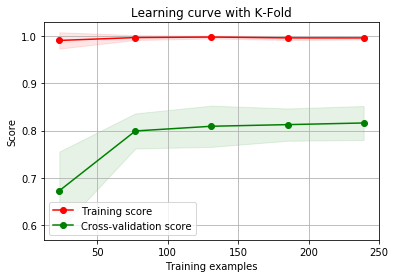

In [45]:
plot_learning_curve(model_RF, "Learning curve with K-Fold", X, y, cv=cv)

In [373]:
# Nested CV with parameter optimization
nested_score = cross_val_score(model_RF, X, y, cv=cv, \
               scoring=make_scorer(classification_report_with_accuracy_score))
print (nested_score) 

             precision    recall  f1-score   support

          0       0.83      0.75      0.79        20
          1       0.72      0.81      0.76        16

avg / total       0.78      0.78      0.78        36

             precision    recall  f1-score   support

          0       0.73      0.65      0.69        17
          1       0.71      0.79      0.75        19

avg / total       0.72      0.72      0.72        36

             precision    recall  f1-score   support

          0       0.75      0.75      0.75        20
          1       0.69      0.69      0.69        16

avg / total       0.72      0.72      0.72        36

             precision    recall  f1-score   support

          0       0.60      0.88      0.71        17
          1       0.82      0.47      0.60        19

avg / total       0.72      0.67      0.65        36

             precision    recall  f1-score   support

          0       0.86      0.90      0.88        21
          1       0.86      0.80 

In [374]:
#Train classifier
model_RF.fit(X,y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('lexical_stats', Pipeline(steps=[('stats', LexicalStats()), ('vectors', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('words', TfidfVectorizer(analyzer='word', binary=False, deco...mators=14, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])